# 변동성 돌파 전략 개선 - 동적 매도 전략

기존 전략: 익일 시가 매도
개선 전략: 당일 종가 - (전일 변동폭 × K값) 이하로 하락 시 매도

## 1. 필요한 라이브러리 임포트 및 환경 설정

In [11]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# matplotlib 한글 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. BigQuery 연결 및 데이터 로드 함수

In [12]:
# BigQuery 클라이언트 초기화
def get_bigquery_client():
    service_account_path = "/Users/cg01-piwoo/my_quant/access_info/data/quantsungyong-663604552de9.json"
    credentials = service_account.Credentials.from_service_account_file(
        service_account_path,
        scopes=["https://www.googleapis.com/auth/cloud-platform"]
    )
    return bigquery.Client(credentials=credentials, project=credentials.project_id)

client = get_bigquery_client()

# 데이터 로드 함수 (기존과 동일)
def get_stock_data(ticker, start_date=None, end_date=None):
    date_conditions = []
    if start_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') >= '{start_date}'")
    if end_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') <= '{end_date}'")
    
    date_filter = f"AND {' AND '.join(date_conditions)}" if date_conditions else ""
    
    query = f"""
    WITH raw_data AS (
      SELECT 
        ticker,
        JSON_EXTRACT_ARRAY(data, '$.dates') AS dates_array,
        JSON_EXTRACT_ARRAY(data, '$.open') AS open_array,
        JSON_EXTRACT_ARRAY(data, '$.high') AS high_array,
        JSON_EXTRACT_ARRAY(data, '$.low') AS low_array,
        JSON_EXTRACT_ARRAY(data, '$.close') AS close_array,
        JSON_EXTRACT_ARRAY(data, '$.volume') AS volume_array,
        ARRAY_LENGTH(JSON_EXTRACT_ARRAY(data, '$.close')) AS array_length
      FROM 
        `quantsungyong.finviz_data.stock_data_with_indicators`
      WHERE 
        ticker = '{ticker}'
    ),
    indices AS (
      SELECT r.ticker, pos
      FROM raw_data r,
      UNNEST(GENERATE_ARRAY(0, r.array_length - 1)) AS pos
    )
    SELECT 
      JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') AS date,
      CAST(JSON_EXTRACT_SCALAR(r.open_array[OFFSET(i.pos)], '$') AS FLOAT64) AS open,
      CAST(JSON_EXTRACT_SCALAR(r.high_array[OFFSET(i.pos)], '$') AS FLOAT64) AS high,
      CAST(JSON_EXTRACT_SCALAR(r.low_array[OFFSET(i.pos)], '$') AS FLOAT64) AS low,
      CAST(JSON_EXTRACT_SCALAR(r.close_array[OFFSET(i.pos)], '$') AS FLOAT64) AS close,
      CAST(JSON_EXTRACT_SCALAR(r.volume_array[OFFSET(i.pos)], '$') AS INT64) AS volume
    FROM raw_data r
    CROSS JOIN indices i
    WHERE i.ticker = r.ticker {date_filter}
    ORDER BY date DESC
    """
    
    try:
        df = client.query(query).to_dataframe()
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        print(f"✅ {ticker} 데이터 로드 완료: {len(df)}개 레코드")
        return df
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

## 3. 개선된 변동성 돌파 전략 구현

In [ ]:
def volatility_breakout_improved(df, k_entry=0.5, k_exit=0.7):
    """
    개선된 변동성 돌파 전략
    
    Parameters:
    - df: 주가 데이터프레임
    - k_entry: 진입 K값 (기본 0.5)
    - k_exit: 청산 K값 (기본 0.5)
    
    Returns:
    - DataFrame: 백테스팅 결과
    """
    result = df.copy()
    
    # 전일 Range 계산
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # 진입가 계산 (당일 시가 + 전일 Range × K)
    result['entry_price'] = result['open'] + (result['prev_range'] * k_entry)
    
    # 청산가 계산 (당일 종가 - 전일 Range × K)
    result['exit_price'] = result['close'] - (result['prev_range'] * k_exit)
    
    # 매수 신호: 당일 고가가 진입가보다 높으면
    result['buy_signal'] = result['high'] > result['entry_price']
    
    # 실제 매수가 (진입가)
    result['buy_price'] = result['entry_price']
    
    # 포지션 추적
    result['position'] = 0  # 0: 포지션 없음, 1: 보유 중
    result['returns'] = 0.0
    
    # 백테스팅 로직
    position_entry_price = 0
    
    for i in range(len(result)):
        if i == 0:
            continue
            
        # 포지션이 없고 매수 신호가 있으면
        if result['position'].iloc[i-1] == 0 and result['buy_signal'].iloc[i]:
            result.loc[result.index[i], 'position'] = 1
            position_entry_price = result['buy_price'].iloc[i]
            
        # 포지션이 있으면
        elif result['position'].iloc[i-1] == 1:
            # 다음날 시가가 청산가보다 낮으면 청산
            if i < len(result) - 1:
                next_open = result['open'].iloc[i+1]
                current_exit_price = result['exit_price'].iloc[i]
                
                if next_open < current_exit_price:
                    # 다음날 시가에 청산
                    result.loc[result.index[i], 'returns'] = (
                        (next_open - position_entry_price) / position_entry_price
                    )
                    result.loc[result.index[i+1], 'position'] = 0
                else:
                    # 포지션 유지
                    result.loc[result.index[i], 'position'] = 1
            else:
                # 마지막 날은 종가로 청산
                result.loc[result.index[i], 'returns'] = (
                    (result['close'].iloc[i] - position_entry_price) / position_entry_price
                )
    
    # 누적 수익률 계산
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold 수익률
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    return result

## 4. 기존 전략과 개선 전략 비교 함수

In [14]:
def volatility_breakout_original(df, k=0.5):
    """
    기존 변동성 돌파 전략 (익일 시가 매도)
    """
    result = df.copy()
    
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    result['buy_signal'] = result['high'] > result['target_price']
    result['buy_price'] = result['target_price']
    result['sell_price'] = result['open'].shift(-1)
    
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    result.loc[buy_condition, 'returns'] = (
        (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
        result.loc[buy_condition, 'buy_price']
    )
    
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    return result

## 5. 데이터 로드 및 전략 비교

In [15]:
# 분석 대상 종목
tickers = ['AAAU', 'BYRN', 'ADT', 'PHX', 'AAOI', 'ADD']
start_date = '2021-07-01'

# 데이터 로드
stock_data = {}
for ticker in tickers:
    df = get_stock_data(ticker, start_date)
    if df is not None:
        stock_data[ticker] = df

print(f"\n✅ 총 {len(stock_data)}개 종목 데이터 로드 완료")

✅ AAAU 데이터 로드 완료: 982개 레코드
✅ BYRN 데이터 로드 완료: 989개 레코드
✅ ADT 데이터 로드 완료: 982개 레코드
✅ PHX 데이터 로드 완료: 982개 레코드
✅ AAOI 데이터 로드 완료: 982개 레코드
✅ ADD 데이터 로드 완료: 982개 레코드

✅ 총 6개 종목 데이터 로드 완료


## 6. 전략 성과 비교

In [16]:
# 전략 비교 실행
comparison_results = {}
k_value = 0.5

print("\n📊 기존 전략 vs 개선 전략 비교 (K=0.5):")
print("=" * 100)
print(f"{'티커':^10} | {'기존 전략':^30} | {'개선 전략':^30} | {'개선 효과':^15}")
print(f"{'':^10} | {'수익률':^10}{'거래수':^10}{'승률':^10} | {'수익률':^10}{'거래수':^10}{'승률':^10} | {'수익률 차이':^15}")
print("-" * 100)

for ticker, df in stock_data.items():
    # 기존 전략
    original = volatility_breakout_original(df, k=k_value)
    orig_return = (original['cumulative_returns'].iloc[-1] - 1) * 100
    orig_trades = original['buy_signal'].sum()
    orig_wins = (original['returns'] > 0).sum()
    orig_win_rate = (orig_wins / orig_trades * 100) if orig_trades > 0 else 0
    
    # 개선 전략
    improved = volatility_breakout_improved(df, k_entry=k_value, k_exit=k_value)
    imp_return = (improved['cumulative_returns'].iloc[-1] - 1) * 100
    imp_trades = improved['buy_signal'].sum()
    imp_wins = (improved['returns'] > 0).sum()
    imp_win_rate = (imp_wins / imp_trades * 100) if imp_trades > 0 else 0
    
    # 결과 저장
    comparison_results[ticker] = {
        'original': original,
        'improved': improved
    }
    
    # 출력
    improvement = imp_return - orig_return
    print(f"{ticker:^10} | {orig_return:^9.1f}%{orig_trades:^10}{orig_win_rate:^9.1f}% | "
          f"{imp_return:^9.1f}%{imp_trades:^10}{imp_win_rate:^9.1f}% | {improvement:^14.1f}%")

print("=" * 100)


📊 기존 전략 vs 개선 전략 비교 (K=0.5):
    티커     |             기존 전략              |             개선 전략              |      개선 효과     
           |    수익률       거래수        승률     |    수익률       거래수        승률     |     수익률 차이     
----------------------------------------------------------------------------------------------------


   AAAU    |    nan   %   395      51.6   % |   72.5   %   395      18.0   % |      nan      %
   BYRN    |   28.7   %   430      48.6   % |   21.7   %   430       2.8   % |      -7.0     %
   ADT     |   -37.1  %   426      47.9   % |   -25.7  %   426       6.6   % |      11.4     %
   PHX     |    nan   %   430      47.9   % |   -12.5  %   430       6.5   % |      nan      %
   AAOI    |   412.1  %   446      50.9   % |   126.8  %   446       2.9   % |     -285.3    %
   ADD     |   -60.2  %   356      42.4   % |  -100.0  %   356       5.1   % |     -39.7     %


## 7. 수익률 곡선 시각화

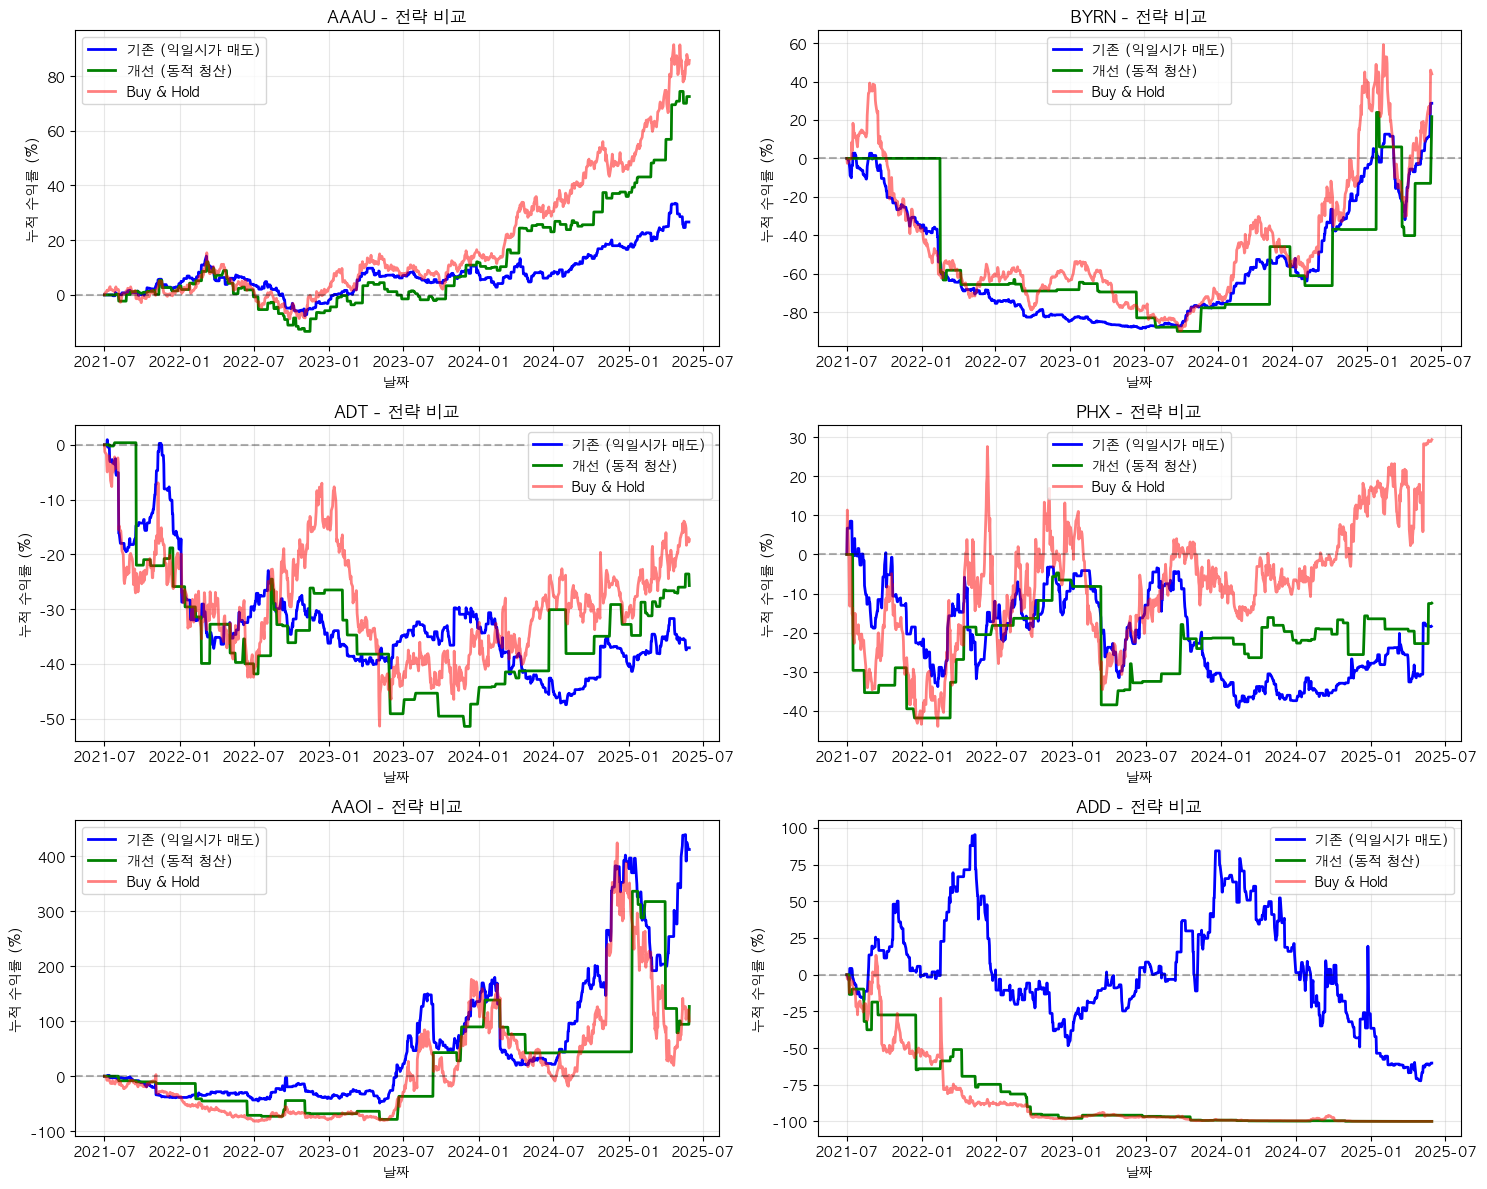

In [17]:
# 전략 비교 시각화
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (ticker, results) in enumerate(comparison_results.items()):
    if idx < len(axes):
        ax = axes[idx]
        
        # 기존 전략
        original = results['original']
        ax.plot(original.index, (original['cumulative_returns'] - 1) * 100, 
                label='기존 (익일시가 매도)', linewidth=2, color='blue')
        
        # 개선 전략
        improved = results['improved']
        ax.plot(improved.index, (improved['cumulative_returns'] - 1) * 100, 
                label='개선 (동적 청산)', linewidth=2, color='green')
        
        # Buy & Hold
        ax.plot(original.index, (original['buy_hold_returns'] - 1) * 100, 
                label='Buy & Hold', linewidth=2, color='red', alpha=0.5)
        
        ax.set_title(f'{ticker} - 전략 비교', fontsize=12, fontweight='bold')
        ax.set_xlabel('날짜')
        ax.set_ylabel('누적 수익률 (%)')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 포지션 보유 기간 분석

In [18]:
print("\n📊 포지션 보유 기간 분석:")
print("=" * 80)

for ticker, results in comparison_results.items():
    improved = results['improved']
    
    # 포지션 변화 추적
    position_changes = improved['position'].diff()
    entries = improved[position_changes == 1].index
    exits = improved[position_changes == -1].index
    
    # 보유 기간 계산
    holding_periods = []
    for i in range(min(len(entries), len(exits))):
        holding_days = (exits[i] - entries[i]).days
        holding_periods.append(holding_days)
    
    if holding_periods:
        avg_holding = np.mean(holding_periods)
        max_holding = np.max(holding_periods)
        min_holding = np.min(holding_periods)
        
        print(f"\n{ticker}:")
        print(f"  평균 보유 기간: {avg_holding:.1f}일")
        print(f"  최장 보유 기간: {max_holding}일")
        print(f"  최단 보유 기간: {min_holding}일")
        print(f"  총 거래 횟수: {len(holding_periods)}회")

print("\n💡 개선 전략은 손실 제한 로직으로 평균 보유 기간이 길어질 수 있습니다.")
print("=" * 80)


📊 포지션 보유 기간 분석:

AAAU:
  평균 보유 기간: 7.5일
  최장 보유 기간: 28일
  최단 보유 기간: 1일
  총 거래 횟수: 126회

BYRN:
  평균 보유 기간: 47.1일
  최장 보유 기간: 225일
  최단 보유 기간: 1일
  총 거래 횟수: 29회

ADT:
  평균 보유 기간: 19.0일
  최장 보유 기간: 75일
  최단 보유 기간: 1일
  총 거래 횟수: 64회

PHX:
  평균 보유 기간: 23.3일
  최장 보유 기간: 85일
  최단 보유 기간: 2일
  총 거래 횟수: 55회

AAOI:
  평균 보유 기간: 41.6일
  최장 보유 기간: 171일
  최단 보유 기간: 1일
  총 거래 횟수: 32회

ADD:
  평균 보유 기간: 19.7일
  최장 보유 기간: 141일
  최단 보유 기간: 1일
  총 거래 횟수: 62회

💡 개선 전략은 손실 제한 로직으로 평균 보유 기간이 길어질 수 있습니다.


## 9. K값 조합 최적화

In [19]:
# 진입/청산 K값 조합 테스트
k_values = [0.3, 0.5, 0.7]
best_combinations = {}

print("\n📊 K값 조합 최적화 (진입 K / 청산 K):")
print("=" * 80)

for ticker, df in stock_data.items():
    best_return = -float('inf')
    best_k_entry = 0
    best_k_exit = 0
    
    results_matrix = []
    
    for k_entry in k_values:
        row_results = []
        for k_exit in k_values:
            result = volatility_breakout_improved(df, k_entry=k_entry, k_exit=k_exit)
            final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
            row_results.append(final_return)
            
            if final_return > best_return:
                best_return = final_return
                best_k_entry = k_entry
                best_k_exit = k_exit
        
        results_matrix.append(row_results)
    
    best_combinations[ticker] = {
        'k_entry': best_k_entry,
        'k_exit': best_k_exit,
        'return': best_return
    }
    
    print(f"\n{ticker}:")
    print(f"  최적 조합: 진입 K={best_k_entry}, 청산 K={best_k_exit}")
    print(f"  수익률: {best_return:.1f}%")
    
    # 결과 매트릭스 출력
    print("\n  청산K →  0.3      0.5      0.7")
    print("  진입K ↓")
    for i, k_entry in enumerate(k_values):
        print(f"    {k_entry}   ", end="")
        for j, ret in enumerate(results_matrix[i]):
            print(f"{ret:7.1f}% ", end="")
        print()

print("=" * 80)


📊 K값 조합 최적화 (진입 K / 청산 K):

AAAU:
  최적 조합: 진입 K=0.3, 청산 K=0.7
  수익률: 105.9%

  청산K →  0.3      0.5      0.7
  진입K ↓
    0.3      96.1%    98.0%   105.9% 
    0.5      73.9%    72.5%    81.2% 
    0.7      45.4%    47.1%    54.0% 

BYRN:
  최적 조합: 진입 K=0.5, 청산 K=0.7
  수익률: 102.8%

  청산K →  0.3      0.5      0.7
  진입K ↓
    0.3      13.6%    52.2%    84.1% 
    0.5     -13.8%    21.7%   102.8% 
    0.7     -22.1%    -4.1%    84.5% 

ADT:
  최적 조합: 진입 K=0.3, 청산 K=0.3
  수익률: 10.0%

  청산K →  0.3      0.5      0.7
  진입K ↓
    0.3      10.0%   -12.4%    -7.7% 
    0.5       8.5%   -25.7%    -8.2% 
    0.7     -12.9%   -33.5%   -11.8% 

PHX:
  최적 조합: 진입 K=0.3, 청산 K=0.5
  수익률: -7.4%

  청산K →  0.3      0.5      0.7
  진입K ↓
    0.3     -28.2%    -7.4%   -10.7% 
    0.5     -41.5%   -12.5%   -16.4% 
    0.7     -61.0%   -40.0%   -35.9% 

AAOI:
  최적 조합: 진입 K=0.5, 청산 K=0.3
  수익률: 761.8%

  청산K →  0.3      0.5      0.7
  진입K ↓
    0.3     359.3%    82.4%   181.6% 
    0.5     761.8%   126.8%   191.9% 

## 10. 개선 전략의 장단점 정리

In [20]:
print("\n📊 개선 전략 분석 요약:")
print("=" * 80)
print("\n장점:")
print("  1. 손실 제한: 하락 시 빠른 청산으로 손실 최소화")
print("  2. 유연성: 진입/청산 K값을 다르게 설정 가능")
print("  3. 추세 추종: 상승 추세에서는 포지션 유지")

print("\n단점:")
print("  1. 복잡성: 구현이 기존 전략보다 복잡")
print("  2. 거래 비용: 조기 청산으로 거래 횟수 증가 가능")
print("  3. 일중 변동성: 변동성이 큰 날 조기 청산 위험")

print("\n💡 권장사항:")
print("  - 변동성이 큰 종목: 청산 K값을 높게 설정 (0.7)")
print("  - 안정적인 종목: 청산 K값을 낮게 설정 (0.3)")
print("  - 진입 K는 기존처럼 0.5 유지")
print("=" * 80)


📊 개선 전략 분석 요약:

장점:
  1. 손실 제한: 하락 시 빠른 청산으로 손실 최소화
  2. 유연성: 진입/청산 K값을 다르게 설정 가능
  3. 추세 추종: 상승 추세에서는 포지션 유지

단점:
  1. 복잡성: 구현이 기존 전략보다 복잡
  2. 거래 비용: 조기 청산으로 거래 횟수 증가 가능
  3. 일중 변동성: 변동성이 큰 날 조기 청산 위험

💡 권장사항:
  - 변동성이 큰 종목: 청산 K값을 높게 설정 (0.7)
  - 안정적인 종목: 청산 K값을 낮게 설정 (0.3)
  - 진입 K는 기존처럼 0.5 유지
